In [1]:
import mne
import numpy as np
import pandas as pd
from scipy.signal import coherence, hilbert
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
import scipy.io
#
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.cm as cm
from matplotlib import colormaps
from networkx.algorithms.community import greedy_modularity_communities, modularity

In [4]:
# Archivo chb01_01.edf
import mne

edf_path = r"C:\Users\shade\OneDrive\Documents\GitHub\Neurociencias-2026-1\S03_datasets\EEG_practica\chb01_01.edf"
raw = mne.io.read_raw_edf(ruta, preload=True)
print(raw)
sfreq_target = 256   
# ====== CARGA Y PREPROCESAMIENTO ======
raw = mne.io.read_raw_edf(edf_path, preload=True)
raw.resample(sfreq_target)
raw.filter(1., 45., fir_design='firwin')
data = raw.get_data()
ch_names = raw.info['ch_names']
n_channels = len(ch_names)

Extracting EDF parameters from C:\Users\shade\OneDrive\Documents\GitHub\Neurociencias-2026-1\S03_datasets\EEG_practica\chb01_01.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\shade\AppData\Local\Temp\ipykernel_15136\2363983057.py:5: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(ruta, preload=True)


<RawEDF | chb01_01.edf, 23 x 921600 (3600.0 s), ~161.7 MiB, data loaded>
Extracting EDF parameters from C:\Users\shade\OneDrive\Documents\GitHub\Neurociencias-2026-1\S03_datasets\EEG_practica\chb01_01.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\shade\AppData\Local\Temp\ipykernel_15136\2363983057.py:9: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(edf_path, preload=True)


Sampling frequency of the instance is already 256.0, returning unmodified.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 45.00 Hz
- Upper transition bandwidth: 11.25 Hz (-6 dB cutoff frequency: 50.62 Hz)
- Filter length: 845 samples (3.301 s)



In [5]:
# ====== MATRIZ DE PHASE LOCKING VALUE (PLV) ======
analytic_signal = hilbert(data)
phase_data = np.angle(analytic_signal)

plv_matrix = np.zeros((n_channels, n_channels))
for i in range(n_channels):
    for j in range(n_channels):
        phase_diff = phase_data[i] - phase_data[j]
        plv_matrix[i, j] = np.abs(np.sum(np.exp(1j * phase_diff)) / phase_diff.size)

plv_df = pd.DataFrame(plv_matrix, index=ch_names, columns=ch_names)
np.fill_diagonal(plv_df.values, 0)

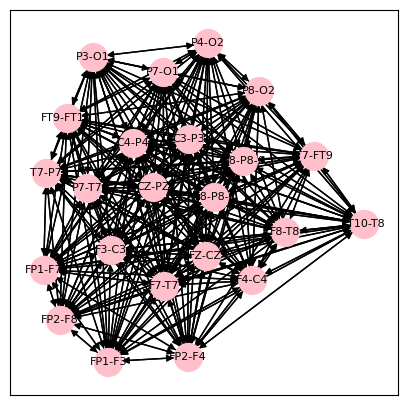

In [21]:
# Grafo 2D
grafo = nx.from_pandas_adjacency(plv_df , create_using=nx.DiGraph) ## umbral para eliminar las conexiones débiles
pos = nx.spring_layout(grafo)
plt.figure(figsize=(5,5))
nx.draw_networkx(grafo, pos, with_labels=True, 
                 node_color='pink', arrows=True, 
                 node_size=400, font_size=8)
plt.show()

In [24]:
# Calculo de comunidades del grafo
from networkx.algorithms.community import greedy_modularity_communities, modularity
G = grafo.to_undirected()
communities = greedy_modularity_communities(G)
mod = modularity(G, communities)
print ('Communities=',communities,'Modularidad=', mod)

Communities= [frozenset({'F7-T7', 'FP1-F7', 'P4-O2', 'F8-T8', 'P8-O2', 'C3-P3', 'FT9-FT10', 'FZ-CZ', 'F3-C3', 'FT10-T8', 'FP1-F3', 'C4-P4', 'FP2-F4', 'P7-T7', 'P3-O1', 'FP2-F8', 'T7-FT9', 'T7-P7', 'T8-P8-0', 'T8-P8-1', 'CZ-PZ', 'P7-O1', 'F4-C4'})] Modularidad= -7.771561172376096e-16


In [25]:
n_channels

23

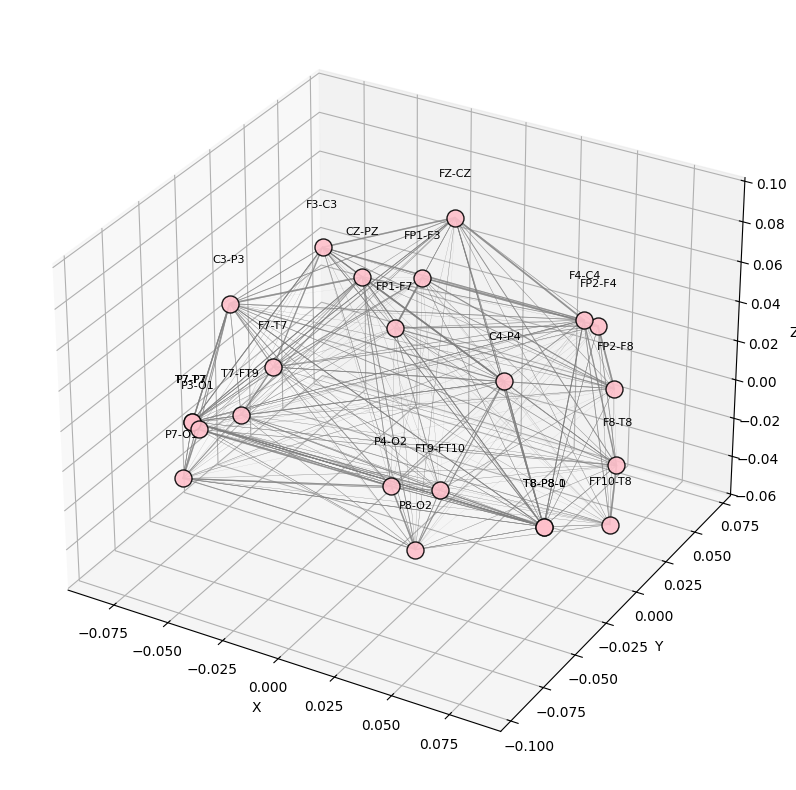

In [32]:
montage = mne.channels.make_standard_montage('standard_1020')
pos = {k.upper(): v for k, v in montage.get_positions()['ch_pos'].items()}
for canal in ch_names:
    try:
        elec1, elec2 = canal.split('-')[:2]
        if elec1 in pos and elec2 in pos:
            pos3D[canal] = tuple((pos[elec1] + pos[elec2]) / 2)
        else:
            print(f"Electrodo no encontrado: {elec1} o {elec2}")
    except ValueError:
        print(f"Formato de canal inválido: {canal}")
G = nx.from_pandas_adjacency(plv_df, create_using=nx.DiGraph)
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
for i, j, d in G.edges(data=True):
    if i in pos3D and j in pos3D:
        x = [pos3D[i][0], pos3D[j][0]]
        y = [pos3D[i][1], pos3D[j][1]]
        z = [pos3D[i][2], pos3D[j][2]]
        ax.plot(x, y, z, color='gray', alpha=0.6, linewidth=2 * d['weight'])
for canal, (x, y, z) in pos3D.items():
    ax.scatter(x, y, z, s=150, color='pink', edgecolors='k', alpha=0.9)
    ax.text(x, y, z + 0.02, canal, fontsize=8, ha='center')
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
plt.tight_layout()
plt.show()

In [29]:
# Cálculo de hubs
degree_centrality = nx.degree_centrality(G) 
sorted_degree = sorted(degree_centrality.items(), key=lambda x: x[1], reverse=True)
print("hub mayor")
for nodo, valor in sorted_degree[:1]:
    print(nodo, valor)

hub mayor
F8-T8 1.8181818181818183


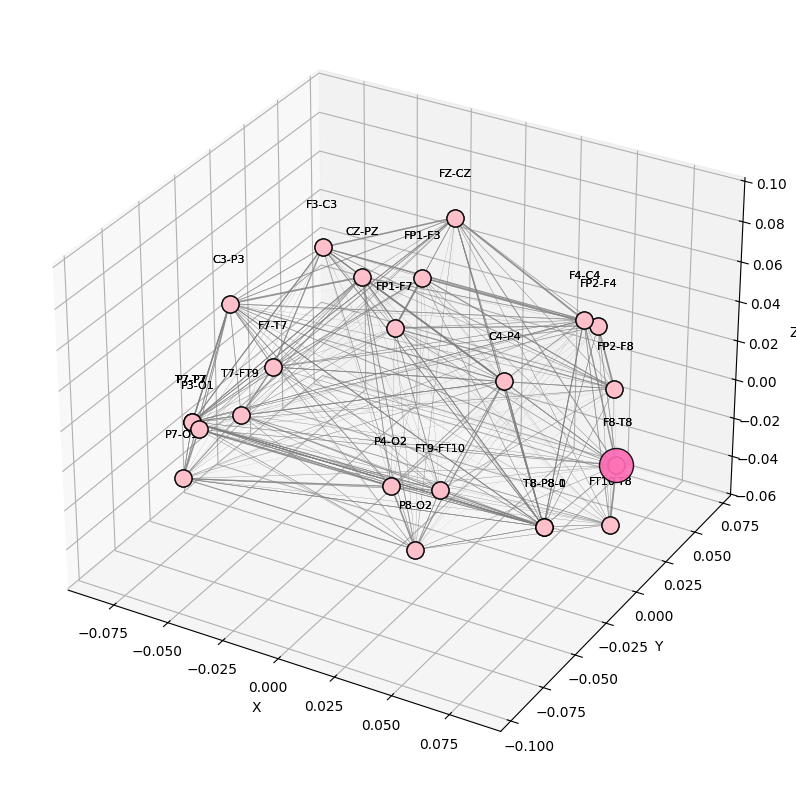

In [33]:
montage = mne.channels.make_standard_montage('standard_1020')
pos = {k.upper(): v for k, v in montage.get_positions()['ch_pos'].items()}
for canal in ch_names:
    try:
        elec1, elec2 = canal.split('-')[:2]
        if elec1 in pos and elec2 in pos:
            pos3D[canal] = tuple((pos[elec1] + pos[elec2]) / 2)
        else:
            print(f"Electrodo no encontrado: {elec1} o {elec2}")
    except ValueError:
        print(f"Formato de canal inválido: {canal}")
G = nx.from_pandas_adjacency(plv_df, create_using=nx.DiGraph)
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
for i, j, d in G.edges(data=True):
    if i in pos3D and j in pos3D:
        x = [pos3D[i][0], pos3D[j][0]]
        y = [pos3D[i][1], pos3D[j][1]]
        z = [pos3D[i][2], pos3D[j][2]]
        ax.plot(x, y, z, color='gray', alpha=0.6, linewidth=2 * d['weight'])
for canal, (x, y, z) in pos3D.items():
    ax.scatter(x, y, z, s=150, color='pink', edgecolors='k', alpha=0.9)
    ax.text(x, y, z + 0.02, canal, fontsize=8, ha='center')
for canal, (x, y, z) in pos3D.items():
    if canal == 'F8-T8':
        size = 600  # más grande
        color = 'hotpink'
    else:
        size = 150
        color = 'pink'
    ax.scatter(x, y, z, s=size, color=color, edgecolors='k', alpha=0.9)
    ax.text(x, y, z + 0.02, canal, fontsize=8, ha='center')
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
plt.tight_layout()
plt.show()